### Classify Waste Products Using Transfer Learning

In [2]:
!pip install tensorflow
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn

In [3]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Version of Tensorflow: ", tf.__version__)

Version of Tensorflow:  2.16.2


In [8]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:01<00:00, 686.68file/s]

Finished extracting file
Finished extracting file


In [9]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In [ ]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [12]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [13]:
# Create a test_generator using the test_datagen object
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


In [14]:
# Print the length of the train_generator
print("Length of train_generator:", len(train_generator))

Length of train_generator: 25


Labels: ['O', 'O', 'O', 'O', 'O']


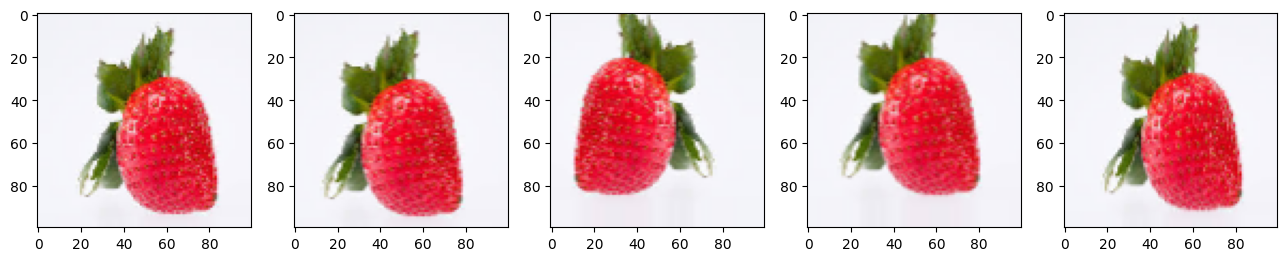

In [15]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [17]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False     

input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Print the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
for layer in basemodel.layers: 
    layer.trainable = False

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [22]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5321 - loss: 0.7545lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5309 - loss: 0.7541 - val_accuracy: 0.7812 - val_loss: 0.5636 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6580 - loss: 0.6046lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6588 - loss: 0.6044 - val_accuracy: 0.6667 - val_loss: 0.5527 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6743 - loss: 0.6298lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6806 - loss: 0.6194 - val_accuracy: 0.8177 - val_loss: 0.4710 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8095 - loss: 0.5007lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8079 - loss: 0.4997 - val_accuracy: 0.8021 - val_loss: 0.4518 - learning_rate: 7.4082e-05
Epoch 5/10
5

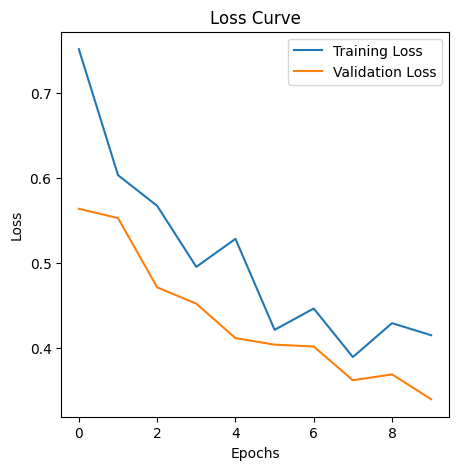

In [ ]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

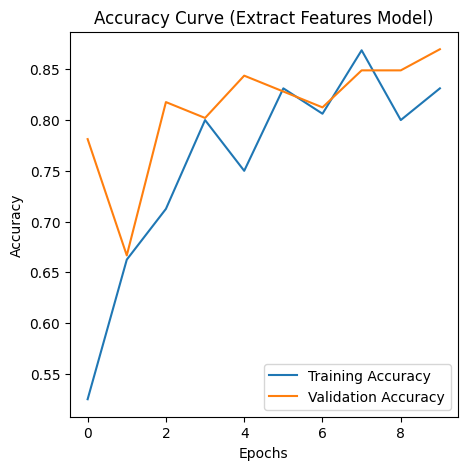

In [25]:
# Plot accuracy curves for training and validation sets
history = extract_feat_model

plt.figure(figsize=(5, 5))
plt.plot(extract_feat_model.history['accuracy'], label='Training Accuracy')
plt.plot(extract_feat_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (Extract Features Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_3: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [27]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5069 - loss: 0.7426lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5193 - loss: 0.7324 - val_accuracy: 0.6979 - val_loss: 0.5493 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6972 - loss: 0.5905lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6893 - loss: 0.5969 - val_accuracy: 0.6354 - val_loss: 0.5886 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7834 - loss: 0.4640lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7862 - loss: 0.4646 - val_accuracy: 0.6771 - val_loss: 0.5776 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7756 - loss: 0.4668lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7797 - loss: 0.4660 - val_accuracy: 0.7969 - val_loss: 0.4298 - learning_rate: 7.4082e-05
Epoch 5/10
5

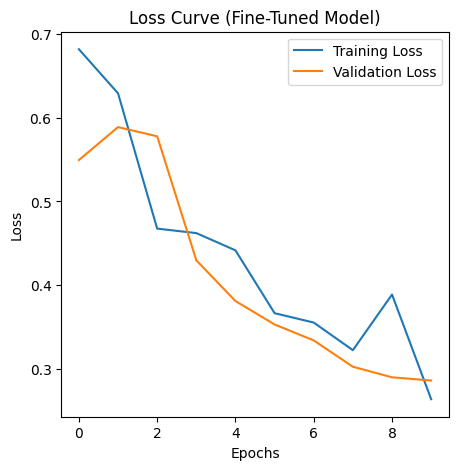

In [29]:
history = fine_tune_model
# Plot loss curves for training and validation sets (fine tune model)
plt.figure(figsize=(5, 5))
plt.plot(fine_tune_model.history['loss'], label='Training Loss')  # Correcto
plt.plot(fine_tune_model.history['val_loss'], label='Validation Loss')  # Correcto
plt.title('Loss Curve (Fine-Tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

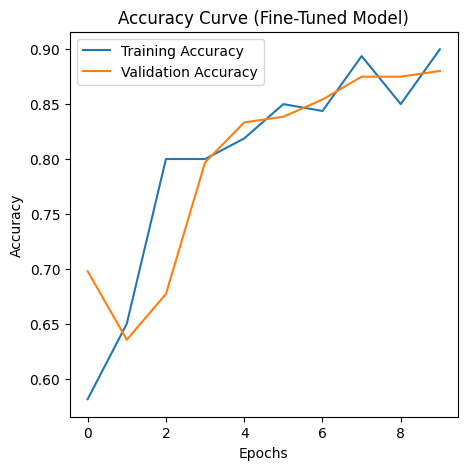

In [30]:
history = fine_tune_model
# Plot accuracy curves for fine-tuned model
plt.figure(figsize=(5, 5))
plt.plot(fine_tune_model.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (Fine-Tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.73      0.90      0.80        50
           R       0.87      0.66      0.75        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.82      0.84      0.83        50
           R       0.84      0.82      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



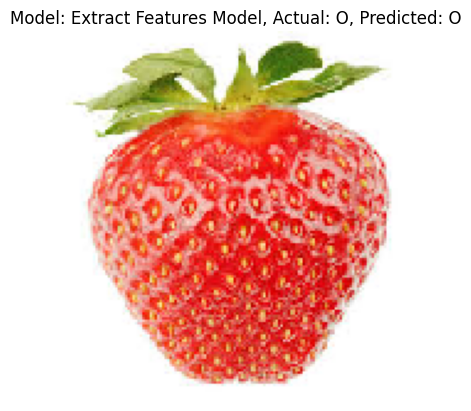

In [32]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

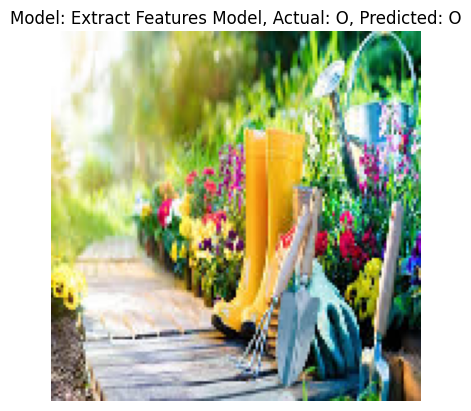

In [ ]:
# Plot test image with Extract Features Model prediction
plot_image_with_title(
    image=test_imgs[1].astype('uint8'),  
    model_name='Extract Features Model',
    actual_label=test_labels[1],          
    predicted_label=predictions_extract_feat_model[1] 
)

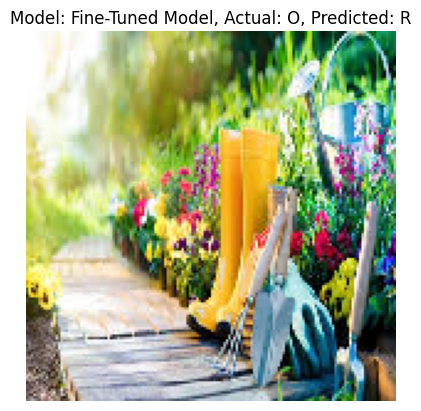

In [34]:
# Plot test image with Fine-Tuned Model prediction
plot_image_with_title(
    image=test_imgs[1].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[1],
    predicted_label=predictions_fine_tune_model[1]
)

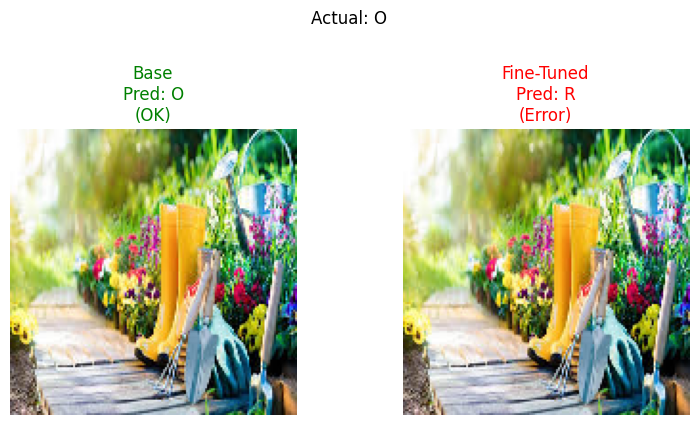

In [36]:
# Plot test image with both models' predictions
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(test_imgs[1].astype('uint8'))
plt.title(f"Base\nPred: {predictions_extract_feat_model[1]}\n(OK)", color='green')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test_imgs[1].astype('uint8'))
plt.title(f"Fine-Tuned\nPred: {predictions_fine_tune_model[1]}\n(Error)", color='red') 
plt.axis('off')

plt.suptitle(f"Actual: {test_labels[1]}", y=1.05)
plt.tight_layout()
plt.show()